This project aims to price an out-performance option using Monte Carlo simulation.    

Out-performance option payoffs depends on the prices of multiple assets. Assume that under risk-neutral measure,the prices of these underlying assets are all geometric Browinan Motion.

$$S_T^{(i)}=S_0^{(i)}e^{(r-\frac{1}{2}\sigma^{2})T+\sigma_iW_T^{(i)}}, i=1,2,3...$$

for an out-performance option, the payoff is:

$$ max(min(S_T^{(1)},...,S_T^{(d)}),K) $$

for stocks with large difference in price, we use percentage change as the payoff,which is:     
$$ max(min(\frac{S_T^1}{S_0^1},\frac{S_T^2}{S_0^2}...),K)$$

in order to use monte-carlo simulation to price the option, we need to first determine the variance-covariance matrix. Here we assume that the variance is constant and compute them from history.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def read_file(file_name):
    df=pd.read_excel(file_name,header=0,index_col=0,parse_dates=True,usecols=list(range(8)))
    return df

aapl=read_file('aapl.xlsx')
msft=read_file('msft.xlsx')
goog=read_file('goog.xlsx')
amzn=read_file('amzn.xlsx')
amzn=amzn.iloc[::-1]   # data cleaning
aapl=aapl.iloc[1:,:]   # remove Nan values
msft=msft.iloc[1:,:]
goog=goog.iloc[1:,:]
amzn=amzn.iloc[1:,:]
aapl.head()

,收盘,净值,涨跌幅,开盘,低值,高值,成交量
交易日期,,,,,,,
2021-03-02,125.12,-2.67,-0.020894,128.41,125.01,128.720,102260945
2021-03-03,122.06,-3.06,-0.024457,124.81,121.84,125.710,112966340
2021-03-04,120.13,-1.93,-0.015812,121.75,118.62,123.600,178154975
2021-03-05,121.42,1.29,0.010738,120.98,117.57,121.935,153766601
2021-03-08,116.36,-5.06,-0.041674,120.93,116.21,121.000,154376610


In [3]:
rtn_mtx=pd.DataFrame(np.concatenate((aapl[['涨跌幅']],msft[['涨跌幅']],goog[['涨跌幅']],amzn[['涨跌幅']]),axis=1),index=aapl.index,columns=['aapl','msft','goog','amzn'])
rtn_mtx.head()

,aapl,msft,goog,amzn
交易日期,,,,
2021-03-02,-0.020894,-0.012957,-0.002724,-0.016404
2021-03-03,-0.024457,-0.026981,-0.023668,-0.028932
2021-03-04,-0.015812,-0.003647,0.011043,-0.009128
2021-03-05,0.010738,0.021479,0.029013,0.007687
2021-03-08,-0.041674,-0.018178,-0.040013,-0.016168


In [4]:
std_array=rtn_mtx.std().values
std_array

array([0.02058076, 0.01632593, 0.01675427, 0.01670781])

In [5]:
cor=rtn_mtx.corr()
cor

,aapl,msft,goog,amzn
aapl,1.000000,0.833797,0.668058,0.788133
msft,0.833797,1.000000,0.689893,0.843785
goog,0.668058,0.689893,1.000000,0.677481
amzn,0.788133,0.843785,0.677481,1.000000


In [6]:
# corr=np.corrcoef(var_mtx.T)
cholesky_decomp=np.linalg.cholesky(cor)
# cholesky_decomp=np.matrix(cholesky_decomp)
cholesky_decomp

array([[1.        , 0.        , 0.        , 0.        ],
       [0.83379719, 0.55207086, 0.        , 0.        ],
       [0.66805789, 0.24067154, 0.70411353, 0.        ],
       [0.78813333, 0.33807494, 0.09884323, 0.50475856]])

Next we construct risk-free interest rate term structure from OIS rate using bootstrap method.

In [13]:
OIS=pd.read_excel('interest_rate.xlsx',header=0,index_col=0,parse_dates=True)
OIS_rate=pd.DataFrame(OIS['RATE/PRICE']/100)
OIS_rate.index.name=None
OIS_rate.columns=['rfr_APR5']
OIS_rate

,rfr_APR5
2022-04-06,0.003351
2022-04-07,0.003368
2022-04-14,0.003474
2022-04-21,0.003512
2022-05-09,0.003780
2022-06-07,0.005670
2022-07-07,0.007560


In [14]:
def rfr(t1:str,t2:str)->float:
    '''
    Calculate the risk-free rate between t1 and t2
    '''
    t0=pd.to_datetime('2022-04-05')
    t1=pd.to_datetime(t1)
    t2=pd.to_datetime(t2)
    t1_t0=(pd.to_datetime(t1)-t0).days/365
    t2_t0=(pd.to_datetime(t2)-t0).days/365
    delta_t=t2_t0-t1_t0
    return (OIS_rate['rfr_APR5'][t2]*t2_t0-OIS_rate['rfr_APR5'][t1]*t1_t0)/delta_t

def delta_t(t:str)->float:
    '''
    Calculate the delta t
    '''
    t0=pd.to_datetime('2022-04-05')
    t=pd.to_datetime(t)
    t_t0=(t-t0).days/365
    return t_t0

In [15]:
term=pd.date_range(start='2022-04-06',end='2022-07-07',freq='B')
rfr_df=pd.DataFrame(index=term,dtype='float64',columns=['rfr_APR5','df'])
rfr_df.update(OIS_rate)

In [16]:
def add_rfr(pillar_date1,pillar_date2):
    date1=pd.to_datetime(pillar_date1)
    date2=pd.to_datetime(pillar_date2)
    for i in pd.date_range(date1+pd.to_timedelta('1 days'),date2-pd.to_timedelta('1 days'),freq='B'):
        rfr1=rfr_df['rfr_APR5'][pillar_date1]   # pillar1的OIS
        rfr2=rfr_df['rfr_APR5'][pillar_date2]
        rfr_m=rfr(pillar_date1,pillar_date2)
        rfr_df.loc[i]['rfr_APR5']=rfr_m
        rfr_df.loc[i]['df']=np.exp(-rfr1*delta_t(pillar_date1)-rfr_m*(delta_t(i)-delta_t(pillar_date1)))
        

In [17]:
add_rfr('2022-04-07','2022-04-14')
add_rfr('2022-04-14','2022-04-21')
add_rfr('2022-04-21','2022-05-09')
add_rfr('2022-05-09','2022-06-07')
add_rfr('2022-06-07','2022-07-07')
rfr_df['df']['2022-04-06']=np.exp(-rfr_df['rfr_APR5']['2022-04-06']*delta_t('2022-04-06'))
rfr_df['df']['2022-04-07']=np.exp(-rfr_df['rfr_APR5']['2022-04-07']*delta_t('2022-04-07'))
rfr_df['df']['2022-04-14']=np.exp(-rfr_df['rfr_APR5']['2022-04-14']*delta_t('2022-04-14'))
rfr_df['df']['2022-04-21']=np.exp(-rfr_df['rfr_APR5']['2022-04-21']*delta_t('2022-04-21'))
rfr_df['df']['2022-05-09']=np.exp(-rfr_df['rfr_APR5']['2022-05-09']*delta_t('2022-05-09'))
rfr_df['df']['2022-06-07']=np.exp(-rfr_df['rfr_APR5']['2022-06-07']*delta_t('2022-06-07'))
rfr_df['df']['2022-07-07']=np.exp(-rfr_df['rfr_APR5']['2022-07-07']*delta_t('2022-07-07'))
rfr_df



,rfr_APR5,df
2022-04-06,0.003351,0.999991
2022-04-07,0.003368,0.999982
2022-04-08,0.003504,0.999972
2022-04-11,0.003504,0.999943
2022-04-12,0.003504,0.999934
...,...,...
2022-07-01,0.011529,0.998265
2022-07-04,0.011529,0.998170
2022-07-05,0.011529,0.998139
2022-07-06,0.011529,0.998107


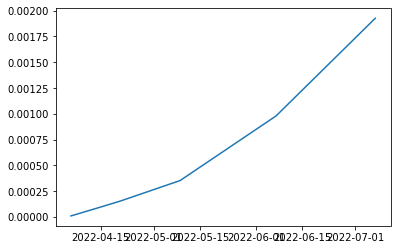

In [43]:
plt.plot(-np.log(rfr_df['df']))
plt.show()

In [9]:
rng=np.random.default_rng(21)
  # 存放St/S0
K=0.8
for i in rfr_df.index:
    St_S0=[]
    Z=rng.standard_normal((4,1))
    Y=np.dot(cholesky_decomp,Z)
    interval=(i-rfr_df.index[0]).days
    for j in range(4):
        Si_S0=1/rfr_df.loc[i,'df']*np.exp(-1/2*std_array[j]**2*interval+std_array[j]*np.sqrt(interval)*Y[j][0])
        St_S0.append(Si_S0)
    minSt_S0=np.min(St_S0) 
    if minSt_S0>K: continue
    else: break
payoff=max(K,minSt_S0)/rfr_df.loc[i,'df']
print(payoff)

NameError: name 'rfr_df' is not defined

In [8]:
rng=np.random.default_rng(21)
Z=rng.standard_normal((4,1))
Y=np.dot(cholesky_decomp,Z)
Y

array([[ 0.35877341],
       [ 1.13314519],
       [-0.65452156],
       [ 1.46824928]])